In [35]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

In [36]:
df = pd.read_csv('train_data.csv', delimiter="\t", header=None)
df.columns = ['id', 'label3', 'label4', 'rating', 'sub']

# NLP
# 1. To lower case
# No need to do this, because lowercase: bool, default=True
# df['sub'] = df['sub'].str.lower()

# 2. Replace useless signs
# The default regexp select tokens of 2 or more alphanumeric characters 
# (punctuation is completely ignored and always treated as a token separator).
df['sub'] = df['sub'].str.replace(r'[\d_.,:()?!;$#*"\'\[\]\\]+', '', regex=True)

# 3. Strip spaces
# df['sub'] = df['sub'].str.replace(r'[\s]+', ' ', regex=True)
# df['sub'] = df['sub'].str.strip()

# 4. Count the number of words in review
df['words'] = [len(x.split()) for x in df['sub'].tolist()]

# 5. Replace review mark with custom classes (eg good and bad)
# df['rating'] = df['rating'].apply(lambda x: 'good' if x > 0.5 else 'bad')

In [37]:
X = df['sub']
y = df['label3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

K = 4

count_vect = CountVectorizer(stop_words={'english'})
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

mn_clf = MultinomialNB()
mn_clf.fit(X_train_tfidf, y_train)

text_clf = Pipeline([
    ('vect', count_vect), 
    ('tfidf', tfidf_transformer), 
    ('clf', mn_clf), 
])

ALPHAS = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
ETAS = [0, 0.1, 10]

scores_svm = []

for alpha in ALPHAS:
    for eta in ETAS:
        model = SGDClassifier(loss='log', alpha=alpha, eta0=eta)
        model.fit(X_train_tfidf, y_train)

        text_clf_svm = Pipeline([
            ('vect', count_vect), 
            ('tfidf', tfidf_transformer), 
            ('clf-svm', model), 
        ])

        score_svm = cross_val_score(text_clf_svm, X_train, y_train, cv=K)
        predicted_svm = text_clf_svm.predict(X_test)
        scores_svm.append([ alpha, eta, score_svm.mean(), np.mean(predicted_svm == y_test), text_clf_svm ])

scores = cross_val_score(text_clf, X_train, y_train, cv=K)

min_model = max(scores_svm, key=lambda x: (x[2] + x[3]) / 2)
scores.mean(), min_model

(0.5617172827172827,
 [0.0001,
  10,
  0.6671633366633367,
  0.7042957042957043,
  Pipeline(steps=[('vect', CountVectorizer(stop_words={'english'})),
                  ('tfidf', TfidfTransformer()),
                  ('clf-svm', SGDClassifier(eta0=10, loss='log'))])])

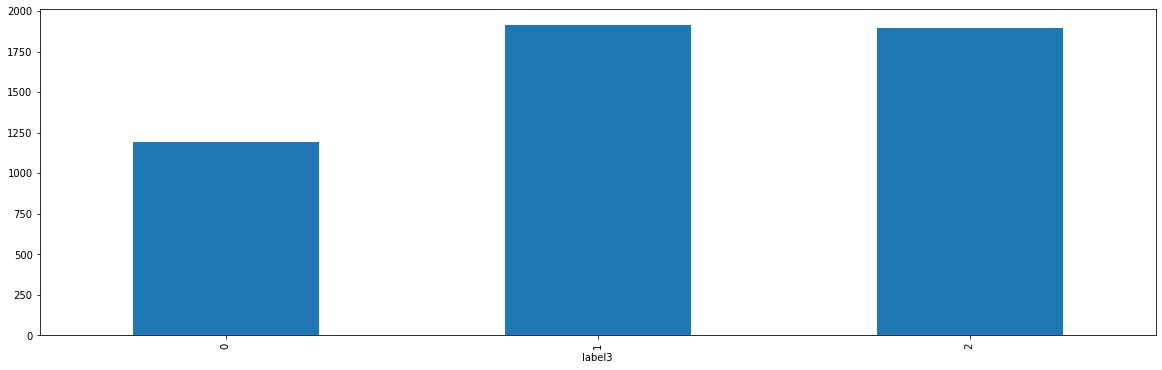

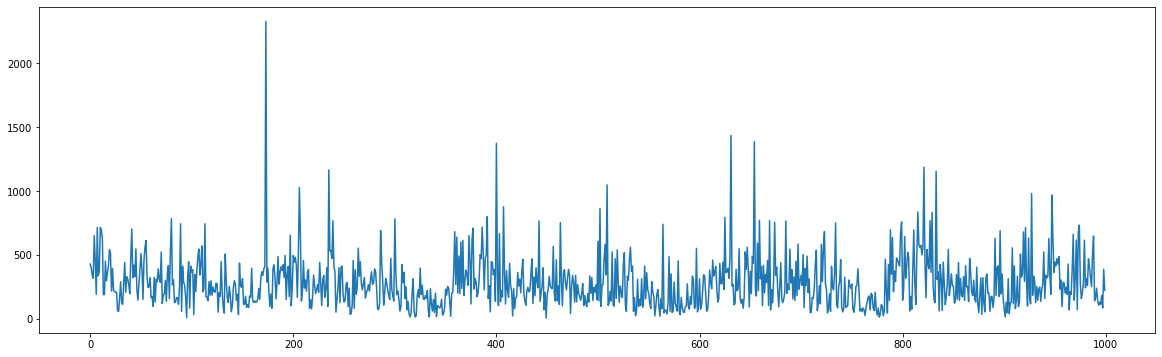

<AxesSubplot:>

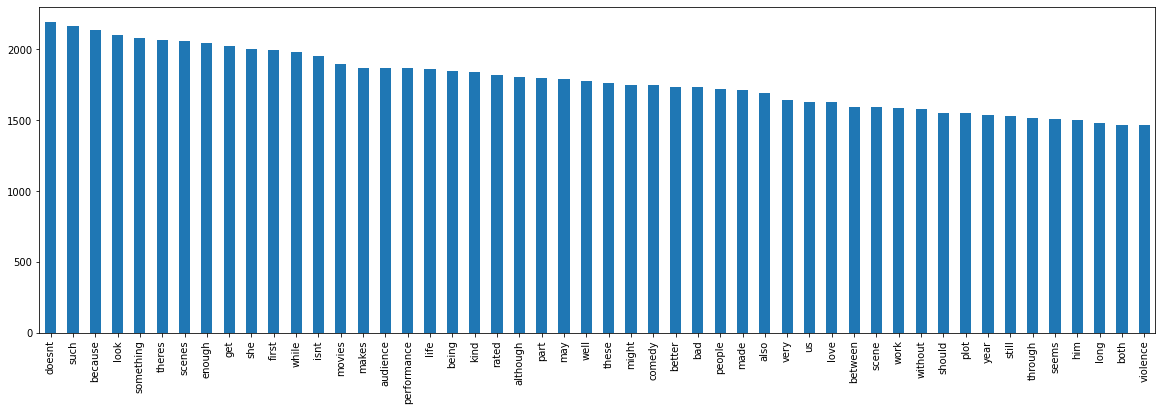

In [42]:
plt.figure(figsize=(20, 6))
df.groupby('label3').size().plot.bar(ylim=0)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(list(range(1000)), df['words'][:1000])
plt.show()

freq = df['sub'].str.split(expand=True).stack().value_counts()

plt.figure(figsize=(20, 6))
freq[100:150].plot(kind='bar')